In [9]:
import os
import random
from typing import Tuple

import imageio.v3 as iio
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from prepare_data.utils import create_folder, get_random_image
from prepare_data.labels import get_box_cords

In [2]:
def show_defects(image: np.ndarray, defects: dict):
    fig, ax = plt.subplots(1, 2, figsize=(10, 15))
    ax[0].imshow(image)
    
    ax[1].imshow(image)
    y_shape, x_shape, _ = image.shape
    for label, cords in defects.items():
        for cord in cords:
            
            x_center = cord[0] * x_shape
            y_center = cord[1] * y_shape
            width = cord[2] * x_shape
            height = cord[3] * y_shape
            
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)

            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax[1].add_patch(rect)


In [3]:
path_to_data = r'../data/prepare_data'

image_path, label_path = get_random_image(path_to_data)
print(image_path)

../data/prepare_data/images/9 (43).jpg


{'2': [[0.498778, 0.461222, 0.282834, 0.160987]]}


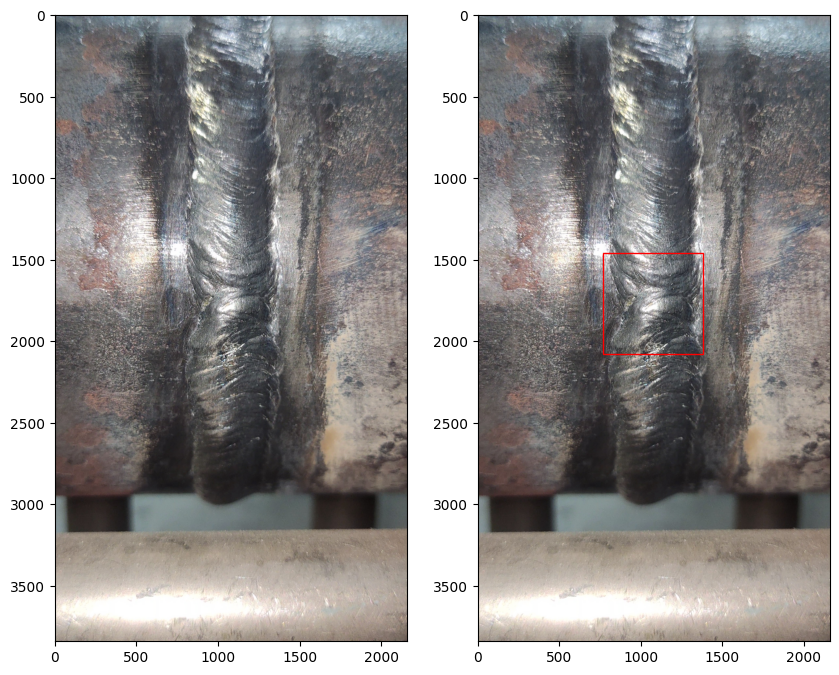

In [4]:
image = iio.imread(image_path)
defects = get_box_cords(label_path)
print(defects)

show_defects(image, defects)

## Generate markup images

In [5]:
def add_labels_to_image(image: np.ndarray, defects: dict, path_to_save: str, color_map: dict):
    fig, ax = plt.subplots(1)
    
    ax.imshow(image)
    y_shape, x_shape, _ = image.shape
    for label, cords in defects.items():
        for cord in cords:
            
            x_center = cord[0] * x_shape
            y_center = cord[1] * y_shape
            width = cord[2] * x_shape
            height = cord[3] * y_shape
            
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)

            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=color_map[label], facecolor='none')
            ax.add_patch(rect)
            
            # top_left_x = x_center - width / 2
            # top_left_y = y_center - height / 2
            # 
            # ax.text(top_left_x, top_left_y + 5, label, color=color_map[label], fontsize=2, ha='left', va='bottom')

    
    ax.axis('off')
    plt.savefig(path_to_save, bbox_inches='tight', pad_inches=0, dpi=1024)
    plt.close(fig)


In [6]:
data_dir = '../data/prepare_data'
path_to_save = '../data/generate_images'
create_folder(path_to_save)

In [7]:
color_map = {'0': 'purple',
             '1': 'orange',
             '2': 'green',
             '3': 'blue',
             '4': 'red'}

for root, dirs, files in os.walk(os.path.join(data_dir, 'images')):
    for file in files:
        path_to_image = os.path.join(root, file)
        path_to_label = os.path.join(data_dir, 'labels', file.replace('jpg', 'txt'))
      
        if file.replace('.jpg', '_label.jpg') in os.listdir(path_to_save):
            continue
            
        image = iio.imread(path_to_image)
        defects = get_box_cords(path_to_label)
      
        print(file, defects)
        add_labels_to_image(image, defects, os.path.join(path_to_save, file.replace('.jpg', '_label.jpg')), color_map)
        
        # break
    # break

5 (126).jpg {'2': [[0.479841, 0.447121, 0.084911, 0.116334]]}
5 (105).jpg {'1': [[0.500611, 0.360752, 0.040929, 0.047004]]}
7 (245).jpg {'2': [[0.513134, 0.482374, 0.124618, 0.057579]], '1': [[0.875076, 0.543478, 0.043372, 0.057579]], '0': [[0.284973, 0.673325, 0.022602, 0.025852], [0.301161, 0.753819, 0.017104, 0.027027], [0.267563, 0.947709, 0.030544, 0.045828], [0.900122, 0.418331, 0.029933, 0.037603]]}
8 (95).jpg {'2': [[0.504887, 0.567568, 0.274282, 0.117509], [0.543677, 0.087544, 0.161271, 0.06463]]}
5 (101).jpg {}
5 (64).jpg {}
7 (63).jpg {'2': [[0.284973, 0.471798, 0.110568, 0.123384]], '1': [[0.848809, 0.39483, 0.124007, 0.042303]], '0': [[0.467318, 0.297297, 0.163714, 0.094007]]}
8 (76).jpg {'2': [[0.508858, 0.222679, 0.274893, 0.135135], [0.507636, 0.553467, 0.25901, 0.115159]], '3': [[0.712584, 0.548766, 0.104459, 0.124559], [0.720831, 0.220329, 0.10507, 0.055229]]}
5 (79).jpg {'1': [[0.453879, 0.959459, 0.062309, 0.07168]]}
8 (32).jpg {'2': [[0.514966, 0.125147, 0.246793, 

In [11]:
def calc_count(cords, label):
    if label not in cords:
        return 0
    
    return len(cords[label])
    

In [25]:
data = pd.DataFrame(columns=['path', 'name', 'video_id', 'frame_id', 'pat0', 'pat1', 'pat2', 'pat3', 'pat4'])
for root, dirs, files in os.walk(os.path.join(data_dir, 'labels')):
    for file in files:
        if 'clas' in file:
            continue
        path_to_label = os.path.join(root, file)
        defects = get_box_cords(path_to_label)
        
        name = file.split('.')[0]

        pattern_before_parentheses = r'(\d+)\s*\('
        video_id = re.search(pattern_before_parentheses, name).group(1)

        pattern_inside_parentheses = r'\((\d+)\)'
        frame_id = re.search(pattern_inside_parentheses, name).group(1)
        
        data = pd.concat((data, pd.DataFrame({'path': path_to_label,
                                              'name': name,
                                              'video_id': video_id,
                                              'frame_id': frame_id,
                                              'pat0': calc_count(defects, '0'),
                                              'pat1': calc_count(defects, '1'),
                                              'pat2': calc_count(defects, '2'),
                                              'pat3': calc_count(defects, '3'),
                                              'pat4': calc_count(defects, '4')}, index=[0])), ignore_index=True)

In [26]:
data

,path,name,video_id,frame_id,pat0,pat1,pat2,pat3,pat4
0,../data/prepare_data/labels/7 (27).txt,7 (27),7,27,5,1,0,2,0
1,../data/prepare_data/labels/11 (1).txt,11 (1),11,1,0,0,1,0,0
2,../data/prepare_data/labels/7 (150).txt,7 (150),7,150,6,1,3,0,1
3,../data/prepare_data/labels/8 (64).txt,8 (64),8,64,0,0,2,0,0
4,../data/prepare_data/labels/8 (68).txt,8 (68),8,68,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...
1157,../data/prepare_data/labels/6 (40).txt,6 (40),6,40,0,0,0,1,0
1158,../data/prepare_data/labels/3 (16).txt,3 (16),3,16,0,0,0,0,0
1159,../data/prepare_data/labels/7 (246).txt,7 (246),7,246,4,1,1,0,0
1160,../data/prepare_data/labels/6 (12).txt,6 (12),6,12,0,0,3,0,0


In [31]:
data['pat0'].sum()

1482

In [27]:
data['pat1'].sum()

388

In [28]:
data['pat2'].sum()

1063

In [29]:
data['pat3'].sum()

287

In [30]:
data['pat4'].sum()

205